# Theoretischer Hintergrund

## Konvexe Hülle
Die konvexe Hülle $CH(vs)$ einer Punktmenge $vs$ in $Q(d)$ entspricht einem Bereich in $Q(d)$.

![Konvexe Hülle](img/ch.PNG)
Das Bild zeigt die konvexe Hülle von Punkten in der Ebene. Sie besteht aus dem schwarz umrandeten Gebiet (inklusive Rand).

## Wertebereich
Wir betrachten eine Teilmenge $Q(d)$ des $d$-dimensionalen Euklidischen Raums $E(d)$, bestehend aus den Punkten, deren Kartesische Koordinaten rationale Zahlen sind. 

Ein Punkt in $Q(d)$ kann als Liste von $d+1$ ganzen Zahlen $[x_0, x_1, . . . , x_d ]$ mit $x_d \neq 0$, dargestellt werden (homogene Koordinaten). 
Diese Liste repräsentiert die $d$ rationalen Kartesischen Koordinaten $[x_0/x_d , x_1/x_d , . . . , x_{d−1}/xd]$
.

Ein Punkt in $Q(d)$ ist eine Liste von ganzen Zahlen:
```Haskell
type Point = [Integer]
```

## Simplex
Ein $d$-Simplex ist die Verallgemeinerung eines Dreiecks in $d$-Dimensionen.
![Simplex](img/simplex.PNG)
Ein $d$-Simplex kann als Liste von $d+1$ Punkten in $Q(d)$ und einem Wert $+1$ oder $-1$, der die Orientierung des Simplex angibt, repräsentiert werden:
```Haskell

type Simplex = ([Point], Int)
```

### Konvexe Menge
Jedes $d$-Simplex $smp$ bestimmt eine konvexe Menge $CS(smp)$ in $Q(d)$. 

Eine Teilmenge des euklidischen Raums (geometrische Figur) ist konvex, wenn für je zwei beliebige Punkte, die zur Menge gehören, auch stets deren Verbindungsstrecke ganz in der Menge liegt.
![konvexe Menge](img/cm1.PNG)

Der Bereich enthält die Punkte innerhalb von $smp$ und auf dessen Grenze.

Um zu bestimmen ob ein Punkt innerhalb oder auf $CS(smp)$ liegt, müssen die **Facetten** von $smp$ berechnet werden.

## Facette
Die Facette eines $d$-Simplex kann als Liste von $d$ Punkten und einer dazugehörigen Orientierung (abgeleitet von dem Simplex), dargestellt werden. 
Beispielsweise sind die Facetten einer Kante ihre zwei Endpunkte, die Facetten eines Dreiecks sind ihre drei Kanten.

```Haskell

type Facet = ([Point], Int)
```

### Beispiel
Ein Dreieck $[a,b,c]$ mit positiver Orientierung im $Q(2)$ hat drei Facetten $([b, c], +1)$, $([a, c],−1)$, $([a, b], +1)$. 
Ein Punkt $p$ befindet sich innerhalb von $[a,b,c]$, wenn die drei Simplexe $ [p, b, c]$, $[p, a, c]$ und $[p, a, b]$ die Orientierungen $+1$, $−1$ und $+1$ haben. 

Implikation:
- $p$ befindet sich links von der Kante $b$ nach $c$
- $p$ befindet sich rechts von der Kante $a$ nach $c$
- $p$ befindet sich links von der Kante $a$ nach $b$

![Triangle](img/triangle1.PNG)

## Prüfkriterium

Die konvexe Hülle $CH(vs)$ ist die **Vereinigung** der Mengen $CS(smp)$ über alle $d$-Simplexe $smp$, die wiederum durch Punkte $vs$ bestimmt werden

In $Q(2)$ bestimmt sich die konvexe Hülle der Punkte $vs$ durch die **Vereinigungsmenge** der Bereiche, die durch alle Dreiecke deren Eckpunkte innerhalb von $vs$ liegen. 

Die Menge $CH(vs)$ lässt sich dementsprechend durch folgendes Prädikat charakterisieren:

```Haskell

insideCH :: [Point] -> Point -> Bool
insideCH vs p = or [insideCS smp p | smp <- simplexes vs]
```

## Determinanten
Die Determinantenberechnungen stammen aus der *Functional Pearl: Three ways of computing determinants* und werden bei der Ermittlung der *Orientierung* benötigt.

In [1]:
minors :: [a] -> [[a]]
minors [] = []
minors (x : xs) = xs : map (x :) (minors xs)

In [2]:
det :: [[Integer]] -> Integer
det [[x ]] = x
det xss = foldr1 (-) (zipWith (*) col1 (map det (minors cols)))
          where col1 = map head xss
                cols = map tail xss

In [3]:
matrix = [[2,2,1],[9,2,5],[3,7,3]]
det matrix

-25

# Inside the Convex Hull
## Ein ineffizienter Algorithmus

In [4]:
import Data.List

type Point = [Integer]
type Simplex = ([Point], Int)
type Facet = ([Point], Int)

dimension :: Point -> Int
dimension ps = length ps - 1

orientation :: [Point] -> Int
orientation = fromIntegral . signum . det

facets :: Simplex -> [Facet]
facets (us, b) = zip (minors us) (cycle [b, -b])

insideCS :: Simplex -> Point -> Bool
insideCS smp p = and [0 <= b * orientation (p : us) | (us, b) <- facets smp]

In [5]:
insideCH :: [Point] -> Point -> Bool
insideCH vs p = or [insideCS smp p | smp <- simplexes vs]

simplexes :: [Point] -> [Simplex]
simplexes vs = [(us, b) | us <- tuples (d + 1) vs,
                          let b = orientation us, b /= 0]
               where d = dimension (head vs)
               
-- Excercise:
-- The value of tuples n vs is a list of all n-tuples of vs; that is, all subsequences
-- of vs of length n. The definition of tuples is left as an exercise.

tuples :: Int -> [a] -> [[a]]
tuples n = filter ((==n) . length) . subsequences

tuples 2 ["a", "b", "c", "d"]

[["a","b"],["a","c"],["b","c"],["a","d"],["b","d"],["c","d"]]

## Ein effizienterer Algorithmus

Für $n$ Punkte gibt es $\mathcal{O}(n^{d+1})$ mögliche $d$-Simplexe. 

Um den Ausdruck `insideCH vs p` zu evaluieren werden also $\mathcal{O} (n^{d+1})$ Schritte benötigt. 

**Allerdings überschneiden sich viele Simplexe.** 

Man muss daher nur eine Teilmenge betrachten, welche die Hülle ohne Überschneidung abdeckt.  

Diese Erkenntnis bildet die Basis für einen effizienteren Algorithmus. 

Vorgehensweise: 
- Ersetze die Funktion `simplexes` durch die Funktion `partition`, welche die konvexe Hülle aufteilt
- `partition` beginnt mit einem einzelnen Simplex und fügt weitere Simplexe hinzu, sobald sich ein neuer Punkt außerhalb der aktuell aufgespannten Hülle befindet

Die Facetten dieser Simplexe können entweder *intern* oder *extern* sein. 
- *Intern*: Treten genau zweimal mit unterschiedlichen Orientierungen auf
- *Extern*: Treten genau einmal auf (Randfacetten)


- Die Funktion `findSimplex` sucht nach einem Simplex. Wenn kein Simplex gefunden wird, gibt es keine Partitionierung und es liegt eine leere Hülle vor. 
- Die externen Facetten werden mit der Funktion `external` ermittelt. 
- Für den Punkt $v$ ist eine Facette $(us, b)$ sichtbar, wenn sich $v$ außerhalb der Facette befindet. 
    - D.h. die Orientierung des Punkts $(v : us)$ hat ein anderes Vorzeichen als die Orientierung der Facette $(us, b)$. 
    - Liegt der Punkt innerhalb der aktuellen konvexen Hülle, gibt es keine sichtbaren Facetten. 
- `newSimplex`: Bei einem update der Hülle wird ein neues Simplex für jede sichtbare Facette hinzugefügt. 

In [6]:
findSimplex :: [Point] -> Maybe Simplex
findSimplex vs = if null smps then Nothing 
                 else Just (head smps)
                 where smps = simplexes vs
    
external :: [Simplex] -> [Facet]
external = foldr op [] . sort . concatMap facets
                       
op :: Facet -> [Facet] -> [Facet]
op smp []     = [smp]
op smp (smp' : smps) = if vertices smp == vertices smp' then smps 
                       else smp : smp' : smps
                       
visible :: Point -> [Facet] -> [Facet]
visible v fs = [(us, b) | (us, b) <- fs, b * orientation (v : us) < 0]

newSimplex :: Point -> Facet -> Simplex
newSimplex v (us, b) = (v : us, -b)

update :: [Simplex] -> Point -> [Simplex]
update smps v = smps ++ map (newSimplex v) (visible v (external smps))

vertices :: Simplex -> [Point]
vertices = sort . fst

In [7]:
insideCH' :: [Point] -> Point -> Bool
insideCH' vs p = or [insideCS smp p | smp <- partition vs] 

partition :: [Point] -> [Simplex]
partition vs
    = case findSimplex vs of
        Nothing -> []
        Just smp -> foldl update [smp] (vs \\ vertices smp)

Wird ein Simplex gefunden, dann wird dieses als Startpunkt verwendet und dessen Eckpunkte werden aus der Liste zusätzlich zu betrachtender Punkte entfernt (Listendifferenz).

## Ein noch effizienterer Algorithmus

In [8]:
insideCH'' vs p = not (null fs) && and [0 <= b * orientation (p : us) | (us, b) <- fs]
                  where fs = faces vs
 
faces :: [Point] -> [Facet]
faces vs = case findSimplex vs of
           Nothing -> []
           Just smp  -> foldl update' (facets smp) (vs \\ vertices smp)
 
update' :: [Facet] -> Point -> [Facet]
update' fs v = (fs \\ fs') ++ map (newFacet v) (external fs')
               where fs' = visible v fs
 
newFacet v (us, b) = (v:us, b)

## QuickCheck

In [9]:
import Test.QuickCheck
 
hullPoints :: Int -> Int -> Gen [[Integer]]
hullPoints d 0  = return []
hullPoints d n  = do { p <- point d; ps <- hullPoints d (n-1); return (p:ps) }

point :: Int -> Gen [Integer]
point d = do { xs <- vector d; return (xs ++ [1]) }

prop_Hull :: Int -> Int -> Property
prop_Hull d n =
    forAll (hullPoints d n) $ \vs ->
    forAll (point d) $ \v ->
    insideCH vs v == insideCH' vs v && insideCH vs v == insideCH'' vs v
 
qc = quickCheck (prop_Hull 2 4)
qc

+++ OK, passed 100 tests.

In [19]:
verboseCheck (prop_Hull 2 10)

Passed:
[[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1]]
[0,0,1]

Passed:
[[-1,0,1],[-1,1,1],[-1,-1,1],[-1,-1,1],[0,-1,1],[-1,1,1],[-1,-1,1],[-1,-1,1],[-1,-1,1],[1,1,1]]
[0,1,1]

Passed:
[[2,-1,1],[2,-1,1],[2,1,1],[-2,-1,1],[2,-2,1],[-2,0,1],[0,1,1],[1,1,1],[2,1,1],[-1,-1,1]]
[0,-1,1]

Passed:
[[1,-2,1],[2,3,1],[-1,1,1],[0,-2,1],[-3,-2,1],[2,-1,1],[-2,-2,1],[-2,3,1],[3,1,1],[2,3,1]]
[-3,0,1]

Passed:
[[1,3,1],[4,2,1],[4,-1,1],[3,0,1],[-1,2,1],[1,-3,1],[1,4,1],[3,-3,1],[3,1,1],[1,3,1]]
[3,-3,1]

Passed:
[[4,2,1],[-5,-4,1],[-2,-4,1],[2,-1,1],[-5,-1,1],[1,-1,1],[4,4,1],[-1,1,1],[2,-1,1],[-1,-1,1]]
[-1,-4,1]

Passed:
[[2,-3,1],[-6,-4,1],[-2,-6,1],[0,-3,1],[-1,5,1],[3,3,1],[-6,-6,1],[-3,0,1],[5,1,1],[5,-6,1]]
[2,-1,1]

Passed:
[[-7,3,1],[6,-6,1],[-4,3,1],[-6,4,1],[6,7,1],[-3,0,1],[-3,0,1],[0,-7,1],[-4,-6,1],[-6,-4,1]]
[3,-2,1]

Passed:
[[-2,6,1],[-6,3,1],[4,6,1],[-4,-5,1],[7,0,1],[-8,2,1],[-5,-4,1],[-6,-2,1],[-2,0,1],[8,5,1]]
[-7,1,1]

Passed:
[[-8,-7,1],[2,

### Visualisierung

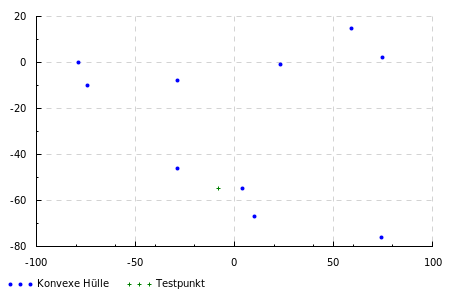

In [15]:
import Graphics.Rendering.Chart.Easy

convexHull = [[10,-67,1],[75,2,1],[-79,0,1],[74,-76,1],[-74,-10,1],[59,15,1],[-29,-8,1],[4,-55,1],[23,-1,1],[-29,-46,1]]
pt = [-8,-55,1]

toRenderable $ do
    plot $ points "Konvexe Hülle" [(x,y) | [x,y,_] <- convexHull]
    plot $ points "Testpunkt" [(x,y) | [x,y,_] <- [pt]]

In [16]:
insideCH convexHull pt

True

In [17]:
insideCH' convexHull pt

True

In [18]:
insideCH'' convexHull pt

True

# Pitfalls
- Determinantenberechnung findet sich in anderer *Functional Pearl*
- `tuples` Funktion muss selbst implementiert werden
- Bug in `partition` Funktion:
     - Das Problem: `Just [smp] -> foldl update [smp] (vs \\ vertices smp)`
     - Lösung: `Just smp -> foldl update [smp] (vs \\ vertices smp)`
- Bug in `op :: Facet -> [Facet] -> [Facet]`:
    - Das Problem: `op smp [] = []`
    - Lösung: `op smp [] = [smp]`